In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

In [2]:
# data imports
df_data = pd.read_csv("data/Modellierung_SoSe23.csv", sep=";", decimal=",", usecols=[0,1,4])

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])
df_price_data["2020_neg"] = df_price_data["2020"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2020_pos"] = 1 - df_price_data["2020_neg"]
df_price_data["2021_neg"] = df_price_data["2021"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2021_pos"] = 1 - df_price_data["2021_neg"]
df_price_data["2022_neg"] = df_price_data["2022"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2022_pos"] = 1 - df_price_data["2022_neg"]

# fill dataframe
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()


df_price_data

,2020,2021,2022,2020_neg,2020_pos,2021_neg,2021_pos,2022_neg,2022_pos
0,0.04188,0.05087,0.05005,0,1,0,1,0,1
1,0.03860,0.04819,0.04133,0,1,0,1,0,1
2,0.03655,0.04468,0.04322,0,1,0,1,0,1
3,0.03232,0.04292,0.04546,0,1,0,1,0,1
4,0.03085,0.04039,0.03767,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...
8755,0.05360,0.03249,-0.00101,0,1,0,1,1,0
8756,0.05238,0.00018,-0.00139,0,1,0,1,1,0
8757,0.04688,0.00008,-0.00104,0,1,0,1,1,0
8758,0.04322,0.00510,-0.00107,0,1,0,1,1,0


In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,Zeit,electric_load,heat_load,pv,temp,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,01.01. 00:00,0.016247,0.22,0.0,12.6,3.315,18.88,1.5104
1,01.01. 01:00,0.016162,0.13,0.0,13.0,3.325,18.89,1.5112
2,01.01. 02:00,0.016005,0.07,0.0,12.6,3.315,18.88,1.5104
3,01.01. 03:00,0.166450,0.03,0.0,12.2,3.305,18.87,1.5096
4,01.01. 04:00,0.016200,0.07,0.0,12.8,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1,3.378,18.94,1.5152
8756,31.12. 20:00,0.261240,1.73,0.0,15.9,3.398,18.96,1.5168
8757,31.12. 21:00,0.289830,1.33,0.0,15.9,3.398,18.96,1.5168
8758,31.12. 22:00,0.340810,0.81,0.0,15.6,3.390,18.95,1.5160


# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [4]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.078    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# grid parameters


# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'capital_cost': (1300*10)/20,
    'marginal_cost': 0,
    'lifespan' : 20,
    'pv_co2': 0   #kg/kWh
}

# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'el_efficiency': 0.8,
    'th_efficiency': 0.2,
    'capital_cost': 500,
    'marginal_cost': 0
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'el_efficiency': 0.625,
    'th_efficiency': 0.2,
    'capital_cost': 500,
    'marginal_cost': 0
}

# heatpump -> wp
wp_params = {
    'p_nom': 12.5,
    'efficiency': df_data['wp_COP_interp'],
    'capital_cost': (25000 / 7.5) / 25,
    'marginal_cost': 0
}

# battery storage
battery_params = { # battery integrated in picea system
    'e_nom': 3.5, #kWh picea system
    'e_nom_min': 2.5,
    #'e_max_pu': 1.0,
    'capital_cost': 450,
    'marginal_cost': 0,
    'standing_loss': 0.0001,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': pv_params['p_nom'],
    'discharge_power': pv_params['p_nom'],
}

# heat storage
heat_storage_params = {
    'e_nom': 20, #kWh
    'e_min_pu': 0.6,
    'e_max_pu': 1.0,
    'e_nom_min': 12,
    'volume': 300, #Litre
    'capital_cost': 650,
    'marginal_cost': 0,
    'standing_loss': 0.08,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
}

# H2 gas storage
h2_storage_params = {
    'e_nom': 1500, #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min' : 1,
    #'e_min_pu_hydrogen': 0.6,
    #'e_max_pu_hydrogen': 1.0,
    'capital_cost': 500, #€ picea system
    'marginal_cost': 0,
    'standing_loss': 0.001,
    'h2_co2': 0   #kg/kWh
}

#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.375 #kg/kWh
}

# Funktionsdefinitionen

### Aufbau des Referenznetzwerks
### Aufbau des Wasserstoff Netzwerkes
### Auswertung

In [5]:
def build_ref_network():

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])

    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'])
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'], 
              e_nom_min = battery_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_min = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [6]:
def build_h2_network():
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    n_h2.add('Carrier', name = 'grid_electricity', 
                co2_emissions = co2_params['co2_emissions_germany_electricity'])
    
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')    
    n_h2.add('Bus', name='pricehandle')
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', p_set = df_data['heat_load'])

    # Generators
    # PV
    n_h2.add('Generator', name='pv', bus='pricehandle',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'])
    # grid  
    n_h2.add('Generator', name='grid', bus='pricehandle',
              marginal_cost = df_price_data["2020"],
              p_nom_extendable = True,
              carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom = battery_params['e_nom'],
              e_cyclic = True)
    
    n_h2.add('Store', name='heat_storage', bus='heat_storage_bus',
              e_nom = heat_storage_params['e_nom'],
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_cyclic = True)
    n_h2.add('Store', name= 'h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_min = h2_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    #n_h2.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              #p_nom_extendable = True)
    
    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
             efficiency = heat_storage_params['charge_efficiency'], 
             p_nom_extendable=True,
             p_nom_max = wp_params["p_nom"])
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
             efficiency = heat_storage_params['discharge_efficiency'],
             p_nom_extendable=True,
             p_nom_max = wp_params["p_nom"])
    
    n_h2.add('Link', name='purchase', bus0="pricehandle", bus1="electricity", 
             marginal_cost = df_price_data["2020_neg"] * np.inf,
             p_nom_extendable=True)

    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='pricehandle', bus1='h2_bus', bus2='heat',
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = df_price_data["2020_pos"] * np.inf,
             p_nom_extendable = True)
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True)
    '''
    
    # electrolysis
    n_h2.add('Link', name='ely1', bus0='electricity', bus1='h2_bus',
             efficiency = ely_params['el_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
            carrier = 'h2_electricity')
    
    n_h2.add('Link', name='ely2', bus0='electricity', bus1='heat',
             efficiency = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
            carrier = 'h2_electricity')
    
    # fuellcell
    n_h2.add('Link', name='fc1', bus0='h2_bus', bus1='electricity',
             efficiency = fc_params['el_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
            carrier = 'h2_electricity')
    
    n_h2.add('Link', name='fc2', bus0='h2_bus', bus1='heat',
             efficiency = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
            carrier = 'h2_electricity')
    '''   
    
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2

In [7]:
def auswertungsfunktion(network, sensitivity_variable=0, co2_constraint=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable], columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
       
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
       
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

In [8]:
def opt_series_summary(network):
    date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
    
    co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    print("CO2-Emissionen: ", co2)
    if network == n_h2:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis'])],
                                   axis = 1)
    else:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP'])],
                                   axis = 1)
    
    return df_res_series

In [9]:
def calculate_compare_results(network):
    
    # list of all timeseries resulting from optimization
    ts_results = []
    
    ts_buses = pd.DataFrame(network.buses_t)
    ts_gen = pd.DataFrame(network.generators_t)
    
    ts_results.append(ts_buses, ts_gen)
    
    
    power_supply = network.generators_t.p.grid
    netzeinspeisung_summe= network.generators_t.p.infeed
    pv_ertrag_summe = network.generators_t.p.pv
    charge_bat = network.links_t.p0.charge_bat
    ausspeicherung_summe = network.links_t.p0.discharge_bat
    battery_capacity = network.stores.e_nom_opt.battery
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
    Leistung_wp = (network.links.p_nom_opt.wp)
    
    return ts_results

In [10]:
# Standard szenario - Preisprofil 2020 - optimierung Speicher im Referenz Netzwerk und Festlegung im H2 netzwerk
n_ref = build_ref_network()
n_ref.optimize(solver_name='gurobi')
co2_ref = (n_ref.generators_t.p.sum() / n_ref.generators.efficiency * 
           pd.merge(n_ref.carriers, n_ref.generators.carrier, 
                    left_index = True, 
                    right_on = 'carrier')['co2_emissions']).sum()
print("batterie: ", n_ref.stores.e_nom_opt.battery, "\nheat storage: ", n_ref.stores.e_nom_opt.heat_storage)

n_h2 = build_h2_network()
n_h2.stores.e_nom.battery = n_ref.stores.e_nom_opt.battery
n_h2.stores.e_nom.heat_storage = n_ref.stores.e_nom_opt.heat_storage
n_h2.global_constraints.loc['co2-limit', 'constant'] = co2_ref
n_h2.optimize(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.50it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-jyvb3f4a.lp
Reading time = 0.35 seconds
obj: 227769 rows, 105126 columns, 420488 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105126 columns and 420488 nonzeros
Model fingerprint: 0x891fb530
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 175209 rows and 26284 columns
Presolve time: 0.15s
Presolved: 52560 rows, 78842 columns, 175200 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105126 primals, 227769 duals
Objective: 9.62e+03
Solver model: available
Solver message: 2



batterie:  2.5 
heat storage:  12.0


C:\Users\Marvin\AppData\Local\Temp\ipykernel_47464\127410516.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_47464\127410516.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.36it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-934gw221.lp
Reading time = 0.48 seconds
obj: 306610 rows, 140167 columns, 578169 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 306610 rows, 140167 columns and 578169 nonzeros
Model fingerprint: 0xca052605
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [1e-05, 1e+100]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 232188 rows and 35122 columns
Presolve time: 0.20s
Presolved: 74422 rows, 105045 columns, 275823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140167 primals, 306610 duals
Objective: 7.23e+03
Solver model: available
Solver message: 2



('ok', 'optimal')

CO2-Emissionen:  1136.9379118244215


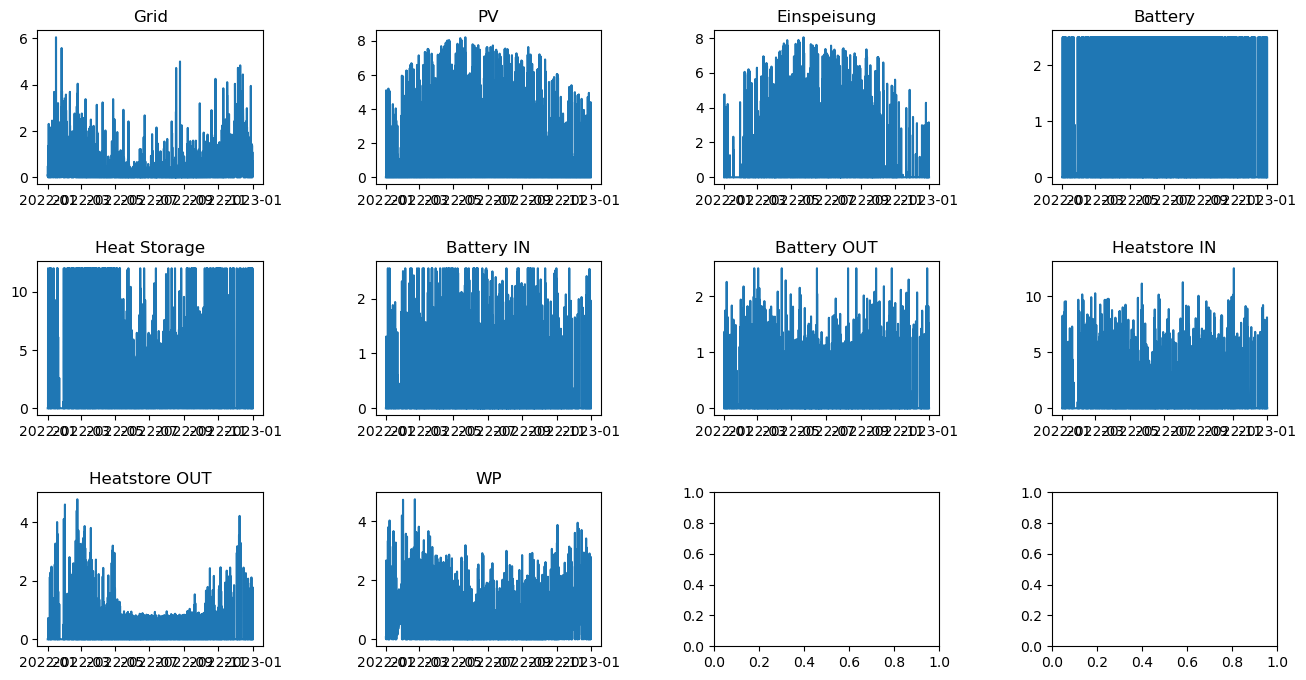

In [11]:
ref_series = opt_series_summary(n_ref)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for col, ax in zip(ref_series.columns, axes.flatten()):
    ax.plot(ref_series.index, ref_series[col])
    ax.set_title(col)
    plt.subplots_adjust(wspace=.5, hspace=.5)


CO2-Emissionen:  1136.9379118200009


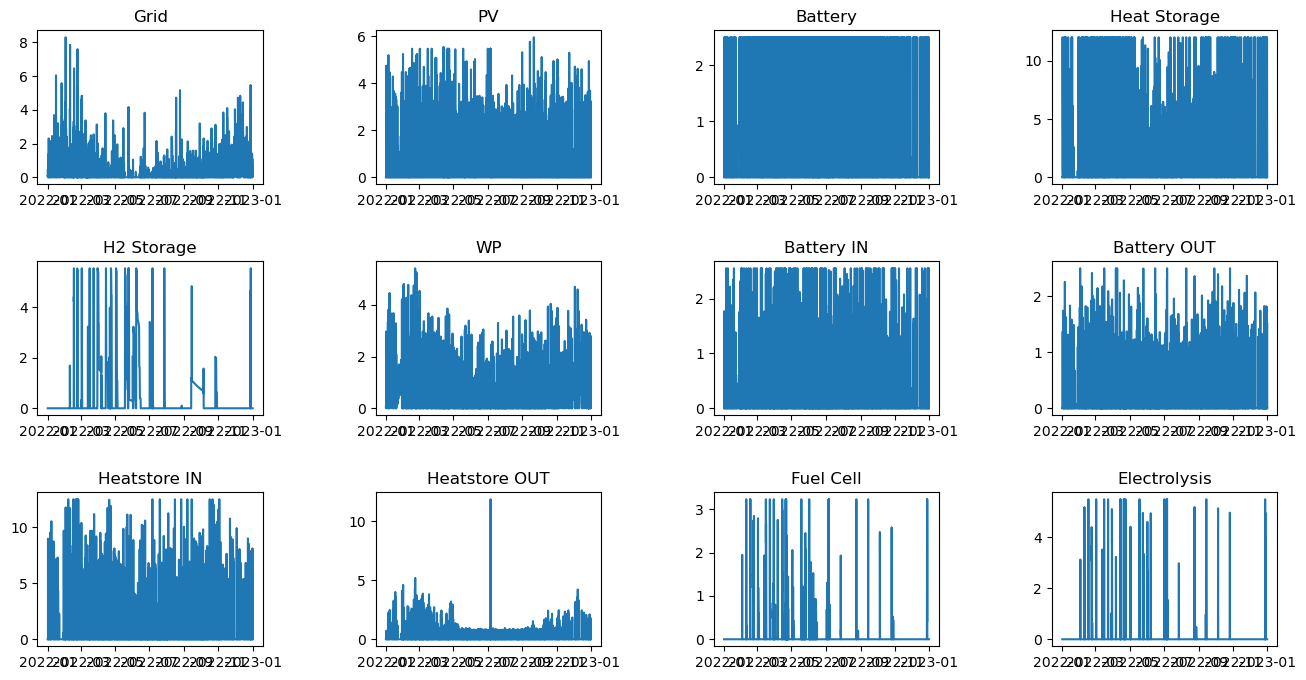

In [12]:
h2_series = opt_series_summary(n_h2)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for col, ax in zip(h2_series.columns, axes.flatten()):
    ax.plot(h2_series.index, h2_series[col])
    ax.set_title(col)
    plt.subplots_adjust(wspace=.5, hspace=.5)

In [13]:
grid_supply_ref = n_ref.generators_t.p.grid.sum()
grid_supply_h2 = n_h2.generators_t.p.grid.sum()

energy_demand = df_data['electric_load'].sum() + df_data['heat_load'].sum()

autarkie_ref = (energy_demand  - grid_supply_ref) / energy_demand
autarkie_h2 = (energy_demand - grid_supply_h2) / energy_demand

print("grid supply reference:", grid_supply_ref)
print("grid supply h2:", grid_supply_h2)

print("autarkie_ref:", autarkie_ref)
print("autarkie_h2:", autarkie_h2)

grid supply reference: 3031.834431531791
grid supply h2: 3031.834431520002
autarkie_ref: 0.7721184530826419
autarkie_h2: 0.7721184530835279


In [ ]:
# szenario verschiedene Preise TEST PV Abnahme
n_h2 = build_h2_network()
co2_values = {}

for year in ["2020", "2021", "2022"]:
    n_h2.generators_t.marginal_cost.grid = df_price_data[year]
    n_h2.links_t.marginal_cost.purchase = df_price_data[year + "_neg"] * np.inf
    n_h2.links_t.marginal_cost.ely = df_price_data[year + "_pos"] * np.inf
    for co2_lim in range(1501, 1000, -250):
        n_h2.global_constraints.loc['co2-limit', 'constant'] = co2_lim
        n_h2.optimize(solver_name='gurobi')
        co2 = (n_h2.generators_t.p.sum() / n_h2.generators.efficiency * 
                       pd.merge(n_h2.carriers, n_h2.generators.carrier, 
                                left_index = True, 
                                right_on = 'carrier')['co2_emissions']).sum()
        co2_values[year + str(co2_lim)] = [co2, n_h2.generators_t.p.pv.sum()]

co2_values

In [ ]:
#co2
n_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#Iterationen
#n_ref = build_ref_network()
#n_h2 = build_h2_network()
n_h2.optimize(solver_name='gurobi')
#results_ref = pd.DataFrame()
#results_h2 = pd.DataFrame()
results_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))
basis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


for co2_limit in np.flip(np.arange(0.8, 1, 0.12)):
    print(co2_limit* basis_co2_emissions)
    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_h2.optimize(solver_name='gurobi')
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))
    
'''
for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_ref.optimize(solver_name = 'gurobi')
    n_h2.optimize(solver_name='gurobi')
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))

'''

In [ ]:
#n_ref = build_ref_network()

n_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen
n_ref.optimize(solver_name='gurobi')

#n_h2 = build_h2_network()
#n_ref.optimize(solver_name='gurobi')

results_ref = auswertungsfunktion(n_ref,100,0)
basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen

for co2_limit in np.flip(np.arange(0.8, 1, 0.12)):
    print(co2_limit* basis_co2_emissions)
    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_ref.optimize(solver_name='gurobi')
    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))

In [ ]:
results_ref

In [ ]:
results_h2 

In [ ]:
# Plots Referenznetzwerk
fig, axes = plt.subplots(4, 4, figsize=(16, 8))

for col, ax in zip(results_ref.columns, axes.flatten()):
    ax.plot(results_ref.index, results_ref[col])
    ax.set_title(col)
    plt.subplots_adjust(wspace=.5, hspace=.5)


In [ ]:
# Plots Referenznetzwerk
fig, axes = plt.subplots(4, 4, figsize=(16, 8))

for col, ax in zip(results_h2.columns, axes.flatten()):
    ax.plot(results_h2.index, results_h2[col])
    ax.set_title(col)
    plt.subplots_adjust(wspace=.5, hspace=.5)